# Face Generation

In this project, I have defined and trained a DCGAN on a dataset of faces. The goal here is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project has been broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, the results of the trained Generator have been visualized to see how it performs; the generated samples look fairly realistic faces with small amounts of noise.


### * [Directly navigate to the results](#results)

### Get the Data

We'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train the adversarial networks.


### Pre-processed Data

Each of the CelebA images has already been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. 

> You can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that we'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, we should be left with a directory of data `processed_celeba_small/`

In [1]:
!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip

--2020-09-16 11:36:07--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.43.182
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.43.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 247694507 (236M) [application/zip]
Saving to: ‘processed-celeba-small.zip’

processed-celeba-sm 100%[===================>] 236.22M  43.7MB/s    in 5.8s    

2020-09-16 11:36:13 (41.1 MB/s) - ‘processed-celeba-small.zip’ saved [247694507/247694507]



In [2]:
# can comment out after executing
!unzip processed-celeba-small.zip

Streaming output truncated to the last 5000 lines.
  inflating: processed_celeba_small/celeba/New Folder With Items/052333.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052334.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052335.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052336.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052337.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052338.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052339.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052340.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052341.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052342.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052343.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052344.jpg  
  inflating: 

In [3]:
data_dir = 'processed_celeba_small/'


import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since we're going to be generating faces, we won't need the annotations, we'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, *some* of the pre-processing has already been done on data. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that are needed to **transform** this data and create a **DataLoader**.

#### While writing the `get_dataloader` function,following requirements have been taken care of:

* The images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* The function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, I have used PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [4]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [5]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # Implement function and return a dataloader

    # transform the tensor
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])

    # get dataset
    dataset = datasets.ImageFolder(data_dir, transform=transform)


    batch_size = 128
    num_workers = 0

    # build DataLoaders 
    data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=num_workers)

    
    return data_loader


## Create a DataLoader

#### Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

* Any reasonable `batch_size` parameter may be used, I have gone for 128
* I have used `image_size` `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [6]:
# Define function hyperparameters
batch_size = 128
img_size = 32

# Get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, we can view some images! We should see square images of somewhat-centered faces.


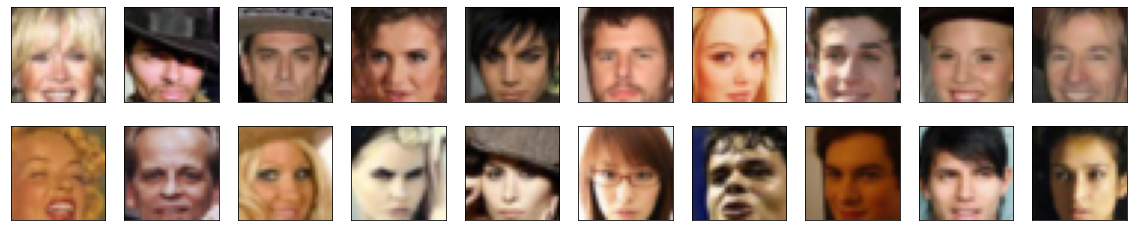

In [7]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Pre-process our image data and scale it to a pixel range of -1 to 1

We need to do a bit of pre-processing; we know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [8]:
# Scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''

    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x


In [9]:
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.7725)
Max:  tensor(0.9922)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Our first task will be to define the discriminator. This is a convolutional classifier, only without any maxpooling layers. To deal with this complex data, I will use a deep network with **normalization**. 

#### Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [10]:
import torch.nn as nn
import torch.nn.functional as F

In [11]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
     
    return nn.Sequential(*layers)

In [12]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # 32x32 in
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        # 2x2 out

        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*8*2*2, 1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)

        # flatten
        x = x.view(-1, self.conv_dim*8*2*2)
        
        # final output layer
        x = self.fc(x)     
        return x


#Test
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [13]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)


In [14]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function

        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*8*2*2)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*8, conv_dim*4, 4)
        self.t_conv2 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv3 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv4 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*8, 2, 2) # (batch_size, depth, 2, 2)
        
        # hidden transpose conv layers + relu
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        
        # last layer + tanh activation
        x = self.t_conv4(x)
        x = F.tanh(x)
        return x

#Test
tests.test_generator(Generator)

Tests Passed


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Initialize the weights of the networks

To help our models converge, we should initialize the weights of the convolutional and linear layers in the model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, our next task will be to define a weight initialization function that does just this!

#### Weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [15]:
from torch.nn import init
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # Apply initial weights to convolutional and linear layers

    if (hasattr(m, 'weight') and (classname.find('Conv')  or classname.find('Linear') != -1)):
        init.normal_(m.weight.data, 0.0, 0.02)    

## Build complete network

Define the models' hyperparameters and instantiate the discriminator and generator from the classes defined above. 

In [16]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Define model hyperparameters

In [17]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=Fal

### Training on GPU

Check if we can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, we also need to make sure that:
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [18]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* We want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Real and Fake loss functions


In [19]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    labels = torch.ones(batch_size)*0.9
    
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # get loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # get loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for the models with appropriate hyperparameters.

In [20]:
import torch.optim as optim
import torch.optim as optim

# hyperparameters
lr = 0.0002
beta1=0.5
beta2=0.999 # default 

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. We'll use the functions `real_loss` and `fake_loss` to help calculate the discriminator losses.

* The discriminator is trained by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

I have also printed out some loss statistics and saved some generated "fake" samples.

#### Training function

In [21]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            ## Train with real images
            d_optimizer.zero_grad()
            if train_on_gpu:
                real_images = real_images.cuda()
            
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            ## Train with fake images
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move z to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            
            g_optimizer.zero_grad()
            
            ## Train with fake images and flipped labels
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # Compute the discriminator losses on fake images 
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels
            
            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss to the losses
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set the number of training epochs and train the GAN!

In [22]:
# set number of epochs 
n_epochs = 30


# call training function
losses = train(D, G, n_epochs=n_epochs)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/   30] | d_loss: 1.3850 | g_loss: 0.7156
Epoch [    1/   30] | d_loss: 0.7134 | g_loss: 1.2966
Epoch [    1/   30] | d_loss: 0.5585 | g_loss: 1.8468
Epoch [    1/   30] | d_loss: 0.9829 | g_loss: 1.3233
Epoch [    1/   30] | d_loss: 1.6673 | g_loss: 1.3974
Epoch [    1/   30] | d_loss: 0.9527 | g_loss: 1.7790
Epoch [    1/   30] | d_loss: 1.0525 | g_loss: 2.2135
Epoch [    1/   30] | d_loss: 0.8366 | g_loss: 2.1953
Epoch [    1/   30] | d_loss: 0.7195 | g_loss: 2.3766
Epoch [    1/   30] | d_loss: 0.8899 | g_loss: 2.6992
Epoch [    1/   30] | d_loss: 0.7211 | g_loss: 2.5622
Epoch [    1/   30] | d_loss: 0.8903 | g_loss: 1.7024
Epoch [    1/   30] | d_loss: 0.7986 | g_loss: 1.8549
Epoch [    1/   30] | d_loss: 0.7378 | g_loss: 2.9670
Epoch [    1/   30] | d_loss: 0.7217 | g_loss: 2.8656
Epoch [    2/   30] | d_loss: 0.8011 | g_loss: 2.4655
Epoch [    2/   30] | d_loss: 0.8721 | g_loss: 2.4916
Epoch [    2/   30] | d_loss: 0.7350 | g_loss: 2.9043
Epoch [    2/   30] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

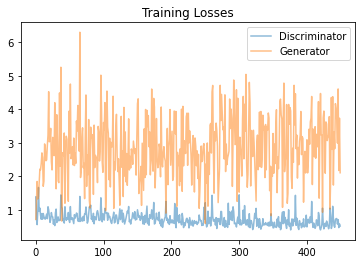

In [23]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

<a id='results'></a>

## Generator samples from training

View newly generated samples of images from the generator.

In [24]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [25]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

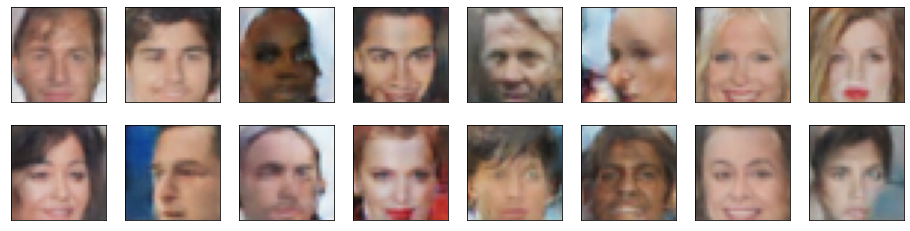

In [32]:
_ = view_samples(-1, samples)

### Scope for Improvement
Considering the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


It can be deduced that:

- The dataset is definitely biased towards white 'celebrities', hence the generated samples also reflect the same. The results would have been more realistic if the generated faces had a range of different skin tones and features.

- I have given both my discriminator and generator four layers each. If the number of layers is increased, more feature maps will be involved, leading to more realistic and better trained results, although it will require more time to tain.

- Some of the generated images are distorted, which I think might be due to the different orientations and angles of faces in dataset. I believe photos from only angle can produce better results. Also, since we have kept the image_size to 32, it resrticts introduction of more convolutional layers. So, using images of better resolution can be an improvement.

- I tried training with different values of epochs, but the loss and generated images do not seem to change much after a certain value. So, keeping the epochs low might be sufficient.

- Also, optimization can be improved by trying other optimizers such as SGD, etc. and trying different learning rates.